# Projeto Final
# João Pedro Moro Bolognini

---
### Criando um modelo de previsão de futuros novos clientes de empréstimo com base em uma série de atributos, para saber se vão honrar seus compromissos futuramente ou não.

Importação das bibliotecas utilizadas

In [173]:
import psycopg2  # Para conexão com o servidor de banco de dados
import pandas as pd
import numpy as np
import statistics as sts
import seaborn as srn
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

Fazendo a conexão com um banco de dados PostgreSQL

In [179]:
conn = psycopg2.connect(
    dbname="ProjetoCCD",
    user="postgres",
    password="admin",
    host="localhost",
    port="5432"
)


cursor = conn.cursor()
consulta = 'SELECT * FROM "CLIENTES"'  # Criando uma consulta para testar a conexão com o banco de dados
cursor.execute(consulta)

# Recuperar os nomes das colunas
nomes_colunas = [desc[0] for desc in cursor.description]

# Recuperar os resultados
resultados = cursor.fetchall()

print(nomes_colunas)
for row in resultados:
    print(row)
    

['idcliente', 'cliente', 'estado', 'sexo']
(1, 'Adelina Buenaventura', 'RJ', 'M')
(2, 'Adelino Gago', 'RJ', 'M')
(3, 'Adélio Lisboa', 'SE', 'M')
(4, 'Adérito Bahía', 'MA', 'M')
(5, 'Adolfo Patrício', 'PE', 'M')
(6, 'Adriana Guedelha', 'RO', 'F')
(7, 'Aida Dorneles', 'RN', 'F')
(8, 'Alarico Quinterno', 'AC', 'M')
(9, 'Alberto Cezimbra', 'AM', 'M')
(10, 'Alberto Monsanto', 'RN', 'M')
(11, 'Albino Canela', 'AC', 'M')
(12, 'Alceste Varanda', 'RR', 'F')
(13, 'Alcides Carvalhais', 'RO', 'M')
(14, 'Aldo Martins', 'GO', 'M')
(15, 'Alexandra Tabares', 'MG', 'F')
(16, 'Alfredo Cotrim', 'SC', 'M')
(17, 'Almeno Figueira', 'SC', 'M')
(18, 'Alvito Peralta', 'AM', 'M')
(19, 'Amadeu Martinho', 'RN', 'M')
(20, 'Amélia Estévez', 'PE', 'F')
(21, 'Ana Homem', 'RN', 'F')
(22, 'Ana Peseiro', 'PA', 'F')
(23, 'Anacleto Garrau', 'TO', 'M')
(24, 'Anacleto Guterres', 'PI', 'M')
(25, 'Andreia Carvalhal', 'SP', 'F')
(26, 'Aníbal Bastos', 'CE', 'M')
(27, 'Anita Beserra', 'PE', 'F')
(28, 'Anna Beça', 'AP', 'F')
(29,

Criando dataframes para todas as tabelas do banco de dados

In [17]:
# Consulta para obter o nome de todas as tabelas no esquema público
consulta_tabelas = """
    SELECT table_name
    FROM information_schema.tables
    WHERE table_schema = 'public' AND table_type = 'BASE TABLE'
"""

# Executar a consulta para obter o nome de todas as tabelas
cursor.execute(consulta_tabelas)

# Recuperar os nomes das tabelas
tabelas = cursor.fetchall()

# Para cada tabela, exportar para um DataFrame
for tabela in tabelas:
    nome_tabela = tabela[0]
    consulta = f'SELECT * FROM "{nome_tabela}"'
    
    # Executar a consulta para obter os dados da tabela
    cursor.execute(consulta)
    
    # Recuperar os resultados da consulta
    resultados = cursor.fetchall()
    
    # Recuperar os nomes das colunas
    nomes_colunas = [desc[0] for desc in cursor.description]
    
    # Criar um DataFrame a partir dos resultados da consulta
    df = pd.DataFrame(resultados, columns=nomes_colunas)
    
    # Exibir o DataFrame (opcional)
    print(f'DataFrame para a tabela {nome_tabela}:')
    print(df)
    
    # Salvar o DataFrame em um arquivo CSV (opcional)
    df.to_csv(f'{nome_tabela}.csv', index=False)

DataFrame para a tabela CLIENTES:
     idcliente               cliente estado sexo
0            1  Adelina Buenaventura     RJ    M
1            2          Adelino Gago     RJ    M
2            3         Adélio Lisboa     SE    M
3            4         Adérito Bahía     MA    M
4            5       Adolfo Patrício     PE    M
..         ...                   ...    ...  ...
245        246  Jandaíra Albuquerque     SP    F
246        247            Joana Ataí     GO    F
247        248       Joaquim Hurtado     AP    M
248        249        Joaquim Mieiro     TO    M
249        250  Joaquina Vasconcelos     SC    F

[250 rows x 4 columns]
DataFrame para a tabela CREDITO:
     IDCREDITO  Duracao  HistoricoCredito  Proposito  Valor  Investimentos  \
0            2       48                 2          1   5951              2   
1            3       12                 1          2   2096              2   
2            4       42                 2          3   7882              2   
3        

Para realizar a predição de crédito, é necessário a tabela crédito, com a coluna status.
Se o status for igual a 1, o cliente vai honrar o compromisso de empréstimo, caso contrário, não irá.

In [22]:
credito = pd.read_csv('CREDITO.csv', sep=",")
credito

,IDCREDITO,Duracao,HistoricoCredito,Proposito,Valor,Investimentos,Emprego,TempoParcelamento,EstadoCivil,FiadorTerceiros,ResidenciaDesde,Idade,OutrosFinanciamentos,Habitacao,EmprestimoExistente,Profissao,Dependentes,SocioEmpresa,Estrangeiro,Status
0,2,48,2,1,5951,2,3.0,2,1,3,2.0,22,3,1.0,1,4,1,0,0,0
1,3,12,1,2,2096,2,4.0,2,4,3,3.0,49,3,1.0,1,3,2,0,0,1
2,4,42,2,3,7882,2,4.0,2,4,4,4.0,45,3,2.0,1,4,2,0,0,1
3,5,24,3,4,4870,2,3.0,3,4,3,4.0,53,3,2.0,2,4,2,0,0,0
4,6,36,2,2,9055,1,3.0,2,4,3,4.0,35,3,2.0,1,3,2,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,505,24,2,4,1207,2,1.0,4,1,3,4.0,24,3,3.0,1,999,1,0,0,0
996,834,24,2,1,5084,1,2.0,2,1,3,4.0,42,3,1.0,1,999,1,1,0,1
997,234,18,0,1,866,2,3.0,4,3,4,2.0,25,3,1.0,1,3,1,0,0,1
998,474,6,0,10,1238,1,5.0,4,4,3,4.0,36,3,1.0,1,1,2,1,0,1


---
# Visualização dos dados

### 1. Dados Numéricos

Valor do empréstimo

In [42]:
credito['Valor'].describe()

count     1000.000000
mean      3271.258000
std       2822.736876
min        250.000000
25%       1365.500000
50%       2319.500000
75%       3972.250000
max      18424.000000
Name: Valor, dtype: float64

Text(0.5, 1.0, 'Valor')

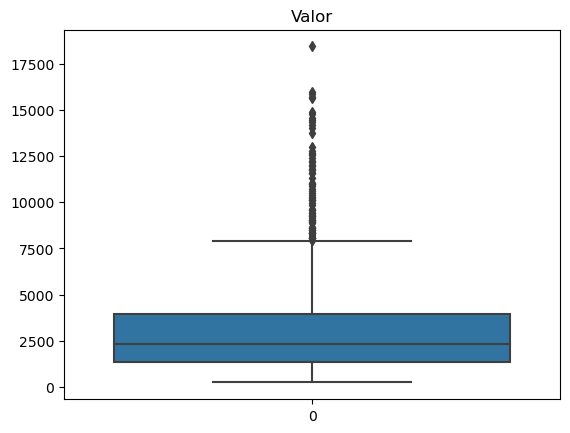

In [47]:
srn.boxplot(credito['Valor']).set_title('Valor')

[Text(0.5, 1.0, 'Valor')]

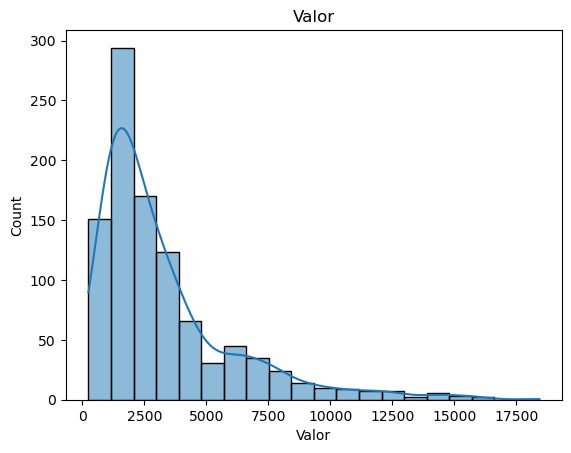

In [94]:
srn.histplot(credito.Valor, kde=True, bins=20).set(title='Valor')

Duração do empréstimo (em meses)

In [43]:
credito['Duracao'].describe()

count    1000.000000
mean       20.903000
std        12.058814
min         4.000000
25%        12.000000
50%        18.000000
75%        24.000000
max        72.000000
Name: Duracao, dtype: float64

Text(0.5, 1.0, 'Duracao')

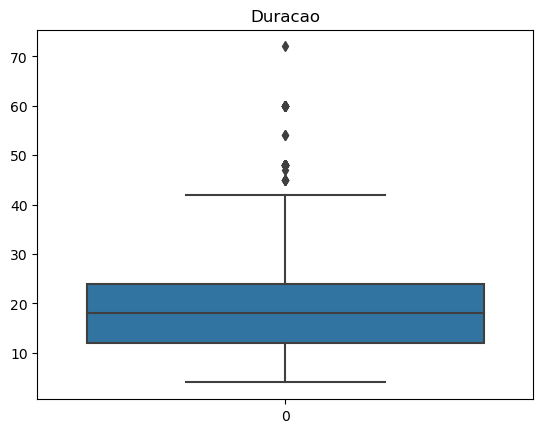

In [48]:
srn.boxplot(credito['Duracao']).set_title('Duracao')

[Text(0.5, 1.0, 'Duracao')]

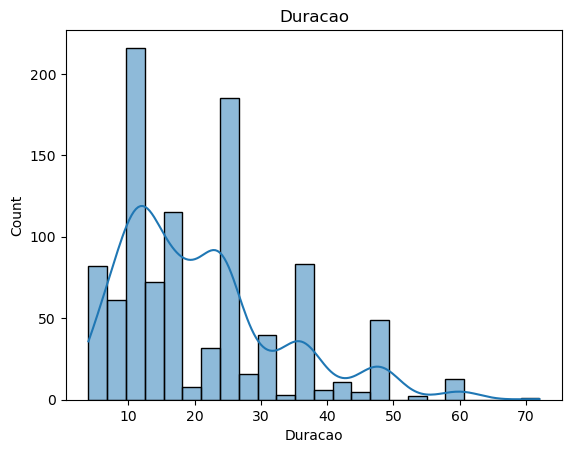

In [93]:
srn.histplot(credito.Duracao, kde=True, bins=24).set(title='Duracao')

Idade do cliente

In [53]:
credito['Idade'].describe()

count    1000.000000
mean       35.546000
std        11.375469
min        19.000000
25%        27.000000
50%        33.000000
75%        42.000000
max        75.000000
Name: Idade, dtype: float64

Text(0.5, 1.0, 'Idade')

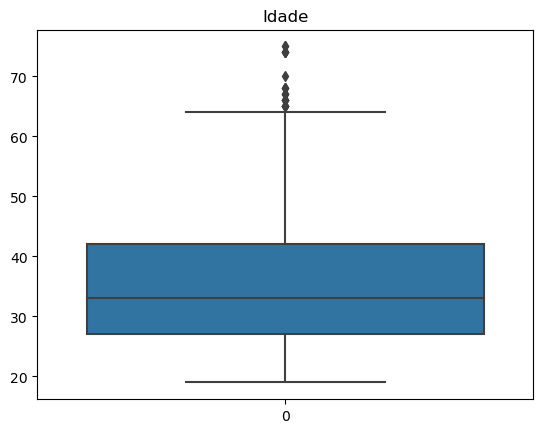

In [49]:
srn.boxplot(credito['Idade']).set_title('Idade')

[Text(0.5, 1.0, 'Idade')]

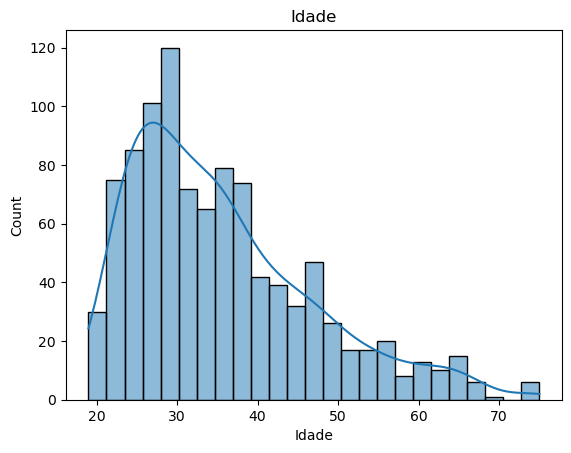

In [92]:
srn.histplot(credito.Idade, kde=True, bins=25).set(title='Idade')

Tempo do parcelamento do empréstimo (em anos)

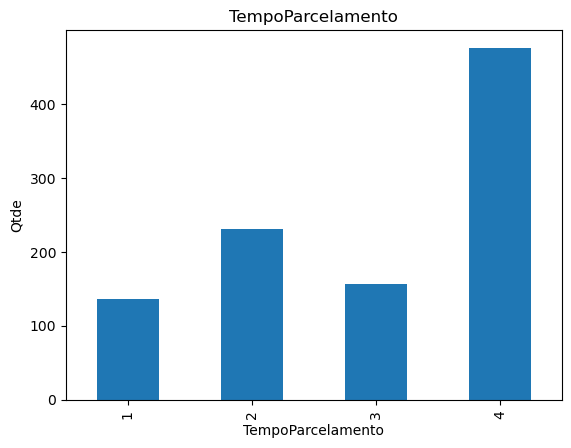

In [104]:
cont = credito['TempoParcelamento'].value_counts()
cont = cont.sort_index()
cont.plot(kind='bar')

plt.xlabel('TempoParcelamento')
plt.ylabel('Qtde')
plt.title('TempoParcelamento')

plt.show()

Quantida de empréstimos que o cliente tem no momento

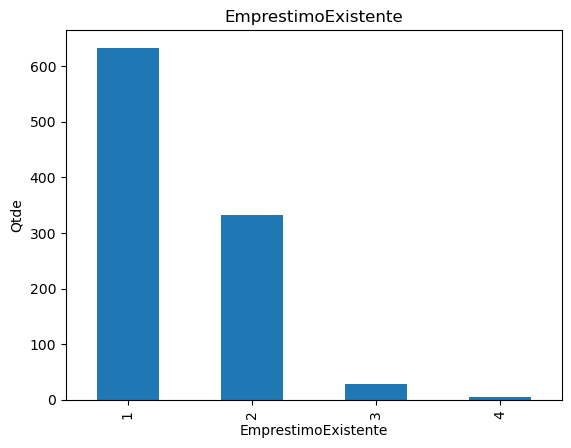

In [105]:
cont = credito['EmprestimoExistente'].value_counts()
cont = cont.sort_index()
cont.plot(kind='bar')

plt.xlabel('EmprestimoExistente')
plt.ylabel('Qtde')
plt.title('EmprestimoExistente')

plt.show()

Quantidade de dependentes que cada cliente possui

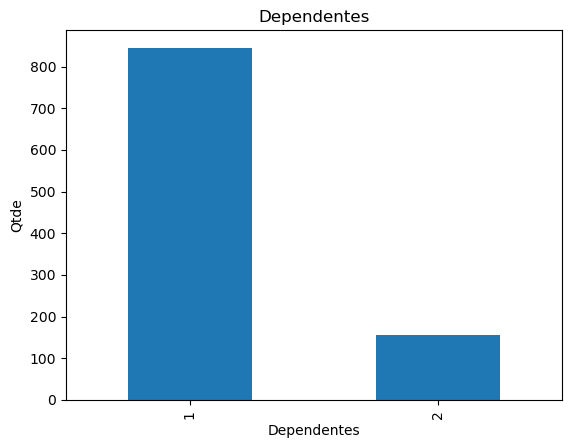

In [106]:
cont = credito['Dependentes'].value_counts()
cont = cont.sort_index()
cont.plot(kind='bar')

plt.xlabel('Dependentes')
plt.ylabel('Qtde')
plt.title('Dependentes')

plt.show()

SocioEmpresa - Verifica se o cliente é sócio de alguma empresa (1) ou não (0)

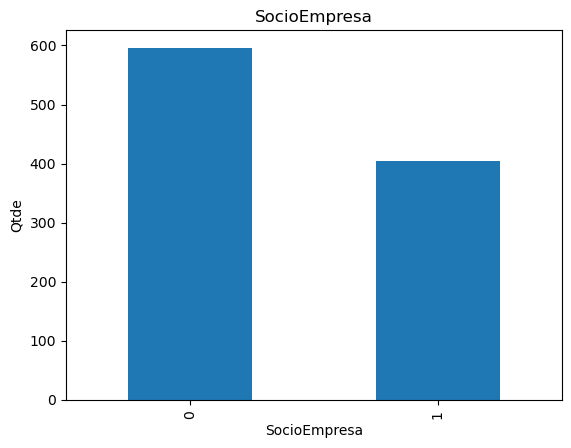

In [107]:
cont = credito['SocioEmpresa'].value_counts()
cont = cont.sort_index()
cont.plot(kind='bar')

plt.xlabel('SocioEmpresa')
plt.ylabel('Qtde')
plt.title('SocioEmpresa')

plt.show()

Estrangeiro - Se o cliente é (1) ou não é (0) estrangeiro

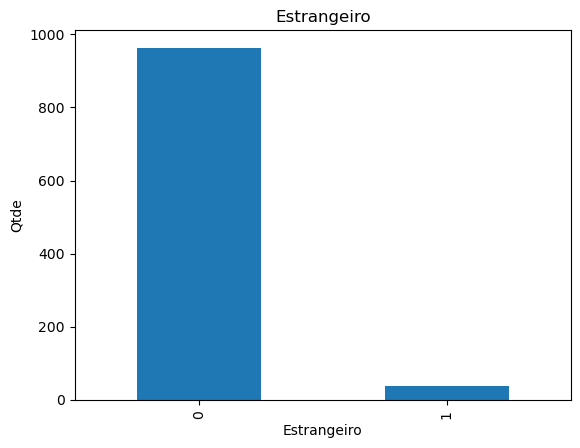

In [108]:
cont = credito['Estrangeiro'].value_counts()
cont = cont.sort_index()
cont.plot(kind='bar')

plt.xlabel('Estrangeiro')
plt.ylabel('Qtde')
plt.title('Estrangeiro')

plt.show()

Status - Se o cliente irá pagar (1) ou não (0) pelo empréstimo

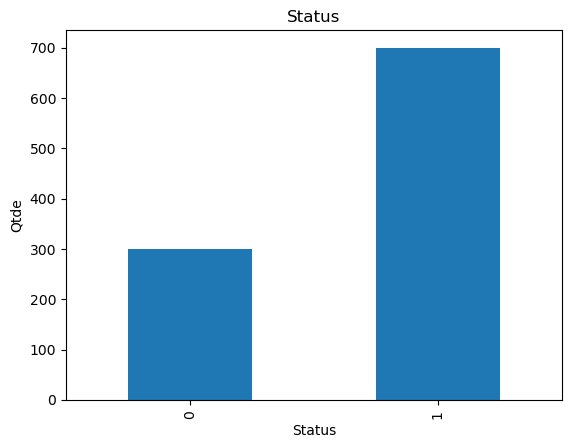

In [109]:
cont = credito['Status'].value_counts()
cont = cont.sort_index()
cont.plot(kind='bar')

plt.xlabel('Status')
plt.ylabel('Qtde')
plt.title('Status')

plt.show()

### 2. Dados Categóricos (Classes)

Histórico de crédito possui classes de 1 a 5.

In [55]:
agrupado = credito.groupby(['HistoricoCredito']).size()
agrupado

HistoricoCredito
0     11
1    289
2    526
3     86
4     40
5     48
dtype: int64

<Axes: xlabel='HistoricoCredito'>

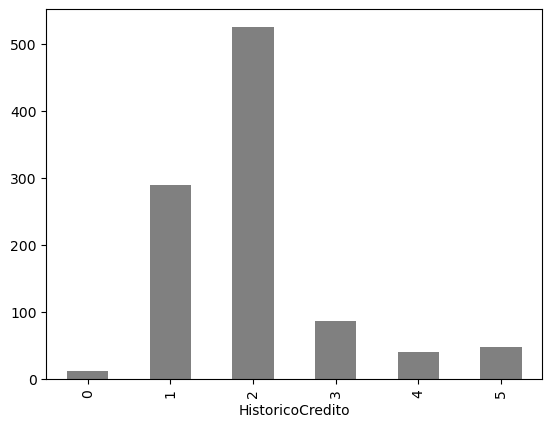

In [56]:
agrupado.plot.bar(color = 'gray')

Investimentos possui classes de 1 a 5.

In [57]:
agrupado = credito.groupby(['Investimentos']).size()
agrupado

Investimentos
1    183
2    603
3     63
4     48
5    103
dtype: int64

<Axes: xlabel='Investimentos'>

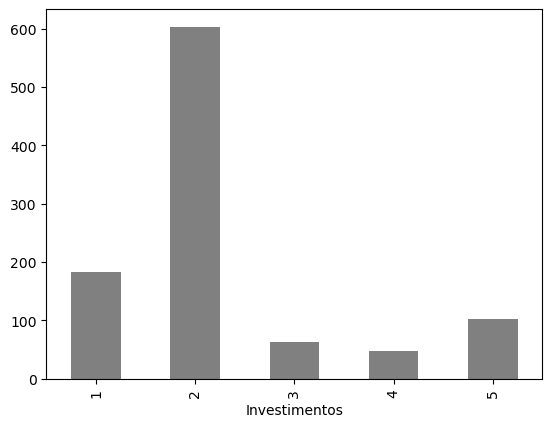

In [58]:
agrupado.plot.bar(color = 'gray')

FiadorTerceiros possui classes de 1 a 4.

In [59]:
agrupado = credito.groupby(['FiadorTerceiros']).size()
agrupado

FiadorTerceiros
1      1
2     39
3    908
4     52
dtype: int64

<Axes: xlabel='FiadorTerceiros'>

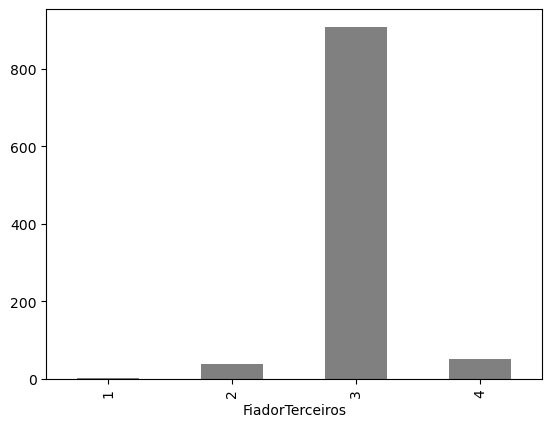

In [60]:
agrupado.plot.bar(color = 'gray')

Proposito tem classes de 1 a 10.

In [62]:
agrupado = credito.groupby(['Proposito']).size()
agrupado

Proposito
1     280
2      50
3     181
4     234
5     103
6      97
7      12
8      22
9      12
10      9
dtype: int64

<Axes: xlabel='Proposito'>

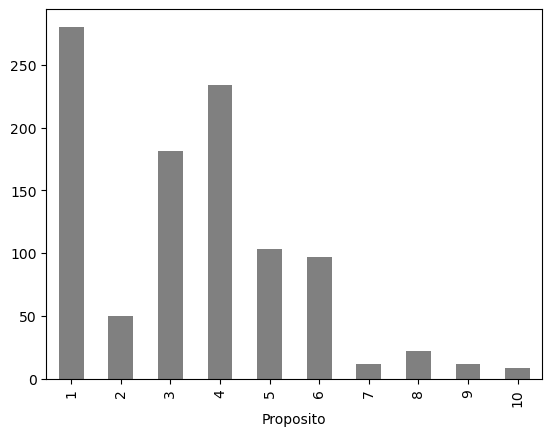

In [63]:
agrupado.plot.bar(color = 'gray')

Emprego tem classes de 1 a 5.

In [64]:
agrupado = credito.groupby(['Emprego']).size()
agrupado

Emprego
1.0    171
2.0    247
3.0    348
4.0    172
5.0     62
dtype: int64

<Axes: xlabel='Emprego'>

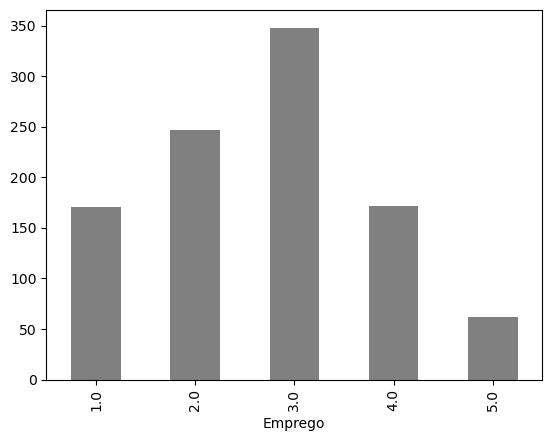

In [65]:
agrupado.plot.bar(color = 'gray')

EstadoCivil tem classes de 1 a 4.

In [66]:
agrupado = credito.groupby(['EstadoCivil']).size()
agrupado

EstadoCivil
1    310
2     50
3     92
4    548
dtype: int64

<Axes: xlabel='EstadoCivil'>

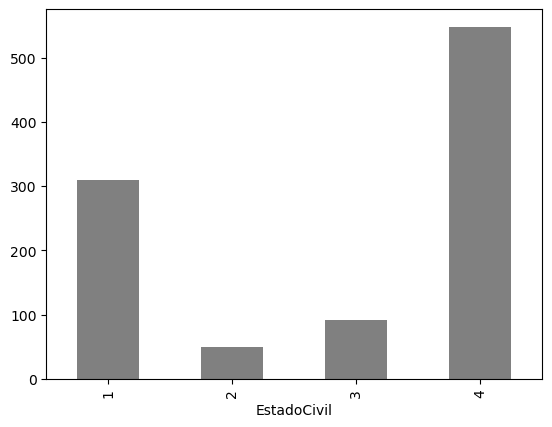

In [67]:
agrupado.plot.bar(color = 'gray')

Habitação tem classes de 1 a 3.

In [68]:
agrupado = credito.groupby(['Habitacao']).size()
agrupado

Habitacao
1.0    718
2.0    107
3.0    175
dtype: int64

<Axes: xlabel='Habitacao'>

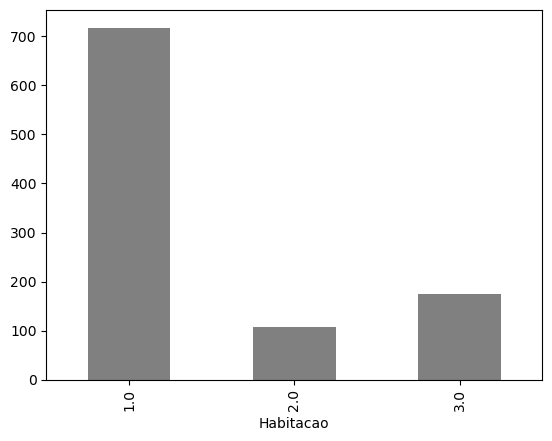

In [69]:
agrupado.plot.bar(color = 'gray')

Profissão tem classes de 1 a 4.

In [70]:
agrupado = credito.groupby(['Profissao']).size()
agrupado

Profissao
1      147
2       22
3      197
4      625
999      9
dtype: int64

<Axes: xlabel='Profissao'>

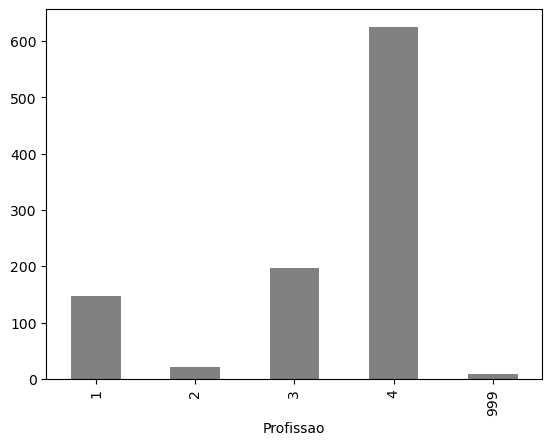

In [71]:
agrupado.plot.bar(color = 'gray')

OutrosFinanciamentos tem classes de 1 a 3.

In [72]:
agrupado = credito.groupby(['OutrosFinanciamentos']).size()
agrupado

OutrosFinanciamentos
1    139
2     47
3    814
dtype: int64

<Axes: xlabel='OutrosFinanciamentos'>

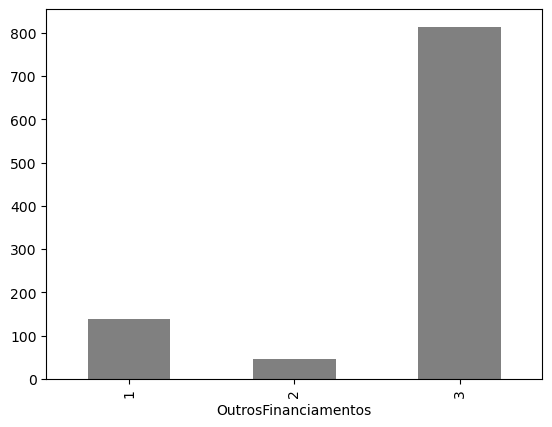

In [73]:
agrupado.plot.bar(color = 'gray')

---
# Limpeza e tratamento dos dados

#### Vamos começar pelos valores nulos

In [110]:
print("Valores nulos:")
print(credito.isnull().sum())

Valores nulos:
IDCREDITO               0
Duracao                 0
HistoricoCredito        0
Proposito               0
Valor                   0
Investimentos           0
Emprego                 0
TempoParcelamento       0
EstadoCivil             0
FiadorTerceiros         0
ResidenciaDesde         0
Idade                   0
OutrosFinanciamentos    0
Habitacao               0
EmprestimoExistente     0
Profissao               0
Dependentes             0
SocioEmpresa            0
Estrangeiro             0
Status                  0
dtype: int64


Habitação, ResidenciaDesde e Emprego são colunas que possuem valores nulos, vamos tratá-los!

In [41]:
# Substituindo os valores pela moda

moda = sts.mode(credito['Habitacao'])
credito['Habitacao'].fillna(moda, inplace=True)

moda = sts.mode(credito['ResidenciaDesde'])
credito['ResidenciaDesde'].fillna(moda, inplace=True)

moda = sts.mode(credito['Emprego'])
credito['Emprego'].fillna(moda, inplace=True)

# Verificando se ainda há valores nulos
print("Valores nulos:")
print(credito.isnull().sum())

Valores nulos:
IDCREDITO               0
Duracao                 0
HistoricoCredito        0
Proposito               0
Valor                   0
Investimentos           0
Emprego                 0
TempoParcelamento       0
EstadoCivil             0
FiadorTerceiros         0
ResidenciaDesde         0
Idade                   0
OutrosFinanciamentos    0
Habitacao               0
EmprestimoExistente     0
Profissao               0
Dependentes             0
SocioEmpresa            0
Estrangeiro             0
Status                  0
dtype: int64


#### Agora os valores fora do domínio das classes

HistóricoCredito e Profissao posuem valores fora do domínio de valores possíveis para as classes, vamos tratá-los!

In [79]:
print("Antes do ajuste: ")
print(credito.groupby(['HistoricoCredito']).size())
print(credito.groupby(['Profissao']).size())

moda = sts.mode(credito['HistoricoCredito'])
# credito['HistoricoCredito'].fillna(moda, inplace=True)
credito.loc[credito['HistoricoCredito'] ==  0, 'HistoricoCredito'] = moda

moda = sts.mode(credito['Profissao'])
# credito['Profissao'].fillna(moda, inplace=True)
credito.loc[credito['Profissao'] == 999 , 'Profissao'] = moda

print("Depois do ajuste: ")
print(credito.groupby(['HistoricoCredito']).size())
print(credito.groupby(['Profissao']).size())

Antes do ajuste: 
HistoricoCredito
1    289
2    537
3     86
4     40
5     48
dtype: int64
Profissao
1    147
2     22
3    197
4    634
dtype: int64
Depois do ajuste: 
HistoricoCredito
1    289
2    537
3     86
4     40
5     48
dtype: int64
Profissao
1    147
2     22
3    197
4    634
dtype: int64


---
# Definindo o conjunto de variáveis dependentes e independentes

Separando os atributos em classes dependentes e independentes

In [148]:
y = credito.iloc[:, -1].values
X = credito.iloc[:, 1:-1]

Realizando uma seleção de atributos para separar os mais importantes para a definição do status

In [149]:
# Treinar o modelo de Extra Trees Classifier
forest = ExtraTreesClassifier()
forest.fit(X, y)

# Obter as importâncias das features
importancias = forest.feature_importances_

# Obter os nomes das colunas
nomes_colunas = credito.iloc[:, 1:-1].columns.tolist()

# Combinar os nomes das colunas com os valores de importância e as posições das colunas
importance_with_columns = list(zip(nomes_colunas, range(len(nomes_colunas)), importancias))

# Ordenar a lista de importância com base nos valores (em ordem decrescente)
importance_with_columns_sorted = sorted(importance_with_columns, key=lambda x: x[2], reverse=True)

# Imprimir os resultados
for column, position, importance in importance_with_columns_sorted:
    print(f"Posição: {position + 1}, Coluna: {column}, Importância: {importance}")
    
# Irei selecionar as 11 colunas com maior importancia
# 1, 4, 11, 2, 3, 6, 10, 5, 7, 8 e 15

Posição: 1, Coluna: Duracao, Importância: 0.10119703364829682
Posição: 4, Coluna: Valor, Importância: 0.10003780074438542
Posição: 11, Coluna: Idade, Importância: 0.08915942122843044
Posição: 2, Coluna: HistoricoCredito, Importância: 0.07932286710114082
Posição: 3, Coluna: Proposito, Importância: 0.07256199002396513
Posição: 6, Coluna: Emprego, Importância: 0.0682941549070448
Posição: 10, Coluna: ResidenciaDesde, Importância: 0.06327572178432564
Posição: 7, Coluna: TempoParcelamento, Importância: 0.0603026422128096
Posição: 5, Coluna: Investimentos, Importância: 0.05776728457415774
Posição: 8, Coluna: EstadoCivil, Importância: 0.049438530863899405
Posição: 15, Coluna: Profissao, Importância: 0.04777463671261669
Posição: 13, Coluna: Habitacao, Importância: 0.04113111533969275
Posição: 14, Coluna: EmprestimoExistente, Importância: 0.0378283136295581
Posição: 17, Coluna: SocioEmpresa, Importância: 0.034730559931533324
Posição: 12, Coluna: OutrosFinanciamentos, Importância: 0.0341816532582

Criando os conjuntos de treino e teste 70/30

In [164]:
X_treinamento, X_teste, y_treinamento, y_teste = train_test_split(X.values,
                                                                  y,
                                                                  test_size = 0.3,
                                                                  random_state = 1)
X_treinamento.shape

(700, 18)

In [165]:
X_treinamento2 = X_treinamento[:,[1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 15]]
X_teste2 = X_teste[:,[1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 15]]
X_treinamento2.shape

(700, 11)

Separando agora os atributos selecionados anteriormente.

---
# Vamos iniciar a previsão e calcular a acurácia de cada modelo

Utilizando Máquinas de Suporte de Vetor

In [152]:
svm = SVC()
svm.fit(X_treinamento, y_treinamento)

SVC()

In [153]:
previsoes = svm.predict(X_teste)
previsoes

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], d

In [157]:
taxa_acerto = accuracy_score(y_teste, previsoes)
taxa_erro = 1 - taxa_acerto
print(f"Taxa de acerto: {taxa_acerto} - Taxa de erro: {taxa_erro}")

Taxa de acerto: 0.7066666666666667 - Taxa de erro: 0.29333333333333333


In [158]:
svm.fit(X_treinamento2, y_treinamento)

SVC()

In [159]:
previsoes = svm.predict(X_teste2)
previsoes

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], d

In [160]:
taxa_acerto = accuracy_score(y_teste, previsoes)
taxa_erro = 1 - taxa_acerto
print(f"Taxa de acerto: {taxa_acerto} - Taxa de erro: {taxa_erro}")

Taxa de acerto: 0.7066666666666667 - Taxa de erro: 0.29333333333333333


Utilizando Naive Bayes

In [168]:
naive_bayes = GaussianNB()
naive_bayes.fit(X_treinamento, y_treinamento)

GaussianNB()

In [169]:
previsoes = naive_bayes.predict(X_teste)
previsoes

array([0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1], d

In [171]:
confusao = confusion_matrix(y_teste, previsoes)
confusao

array([[ 37,  52],
       [ 40, 171]], dtype=int64)

In [172]:
taxa_acerto = accuracy_score(y_teste, previsoes)
taxa_erro = 1 - taxa_acerto
print(f"Taxa de acerto: {taxa_acerto} - Taxa de erro: {taxa_erro}")

Taxa de acerto: 0.6933333333333334 - Taxa de erro: 0.30666666666666664


Utilizando K-Vizinhos mais próximos

In [174]:
knn = KNeighborsClassifier(n_neighbors = 2)
knn.fit(X_treinamento, y_treinamento)

KNeighborsClassifier(n_neighbors=2)

In [175]:
previsoes = knn.predict(X_teste)
previsoes

array([1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0], d

In [176]:
confusao = confusion_matrix(y_teste, previsoes)
confusao

array([[ 51,  38],
       [ 89, 122]], dtype=int64)

In [177]:
taxa_acerto = accuracy_score(y_teste, previsoes)
taxa_erro = 1 - taxa_acerto
print(f"Taxa de acerto: {taxa_acerto} - Taxa de erro: {taxa_erro}")

Taxa de acerto: 0.5766666666666667 - Taxa de erro: 0.42333333333333334


A melhor taxa de acerto obtida foi com o modelo de SVM. Então, vamos gerar um classificador para ele realizar previsões futuras.

In [ ]:
modelo = SVC()
modelo.fit(X_treinamento2, y_treinamento)

# previsoes = modelo.predict("X_teste")
# previsoes

# taxa_acerto = accuracy_score("y_teste", previsoes)
# taxa_erro = 1 - taxa_acerto
# print(f"Taxa de acerto: {taxa_acerto} - Taxa de erro: {taxa_erro}")